# Urban Cooling Interventions: Complete Methodological Framework

This notebook presents the complete methodology for identifying, optimising, and validating urban cooling interventions across six European cities. Using a systematic grid search over the intervention parameter space (typically more than 2,000 combinations) with hierarchical XGBoost models, we show that strategic depaving and greening can achieve **around 1.1–1.2°C cooling** in high-priority neighbourhoods.


## 1. Environment Setup and Dependencies

### 1.1 Import Requirements

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
from tqdm.notebook import tqdm
from itertools import product
from scipy import stats
from typing import Dict, List, Tuple, Optional
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

import contextily as ctx
from mpl_toolkits.mplot3d import Axes3D

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)


### 1.2 Project Structure and Paths

In [2]:
# Project structure
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Import project modules
import sys
sys.path.append(str(PROJECT_ROOT))

from src.interventions import (
    run_comprehensive_grid_search,
    load_grid_search_results,
    load_intervention_scenarios,
    scenarios_to_frame,
    apply_scenario_deltas,
    filter_extreme_predictions,
    predict_blend,
    InterventionScenario
)
from src.model_preprocessing import build_model_dataset
from src.plotting_utils import load_grid_geodataframe

# Define paths
PATHS = {
    'data': PROJECT_ROOT / 'data',
    'results': PROJECT_ROOT / 'results',
    'models': PROJECT_ROOT / 'results' / 'modeling',
    'scenarios': PROJECT_ROOT / 'results' / 'scenarios',
    'risk': PROJECT_ROOT / 'results' / 'risk_vulnerability',
    'figures': PROJECT_ROOT / 'results' / 'figures',
    'tables': PROJECT_ROOT / 'results' / 'tables',
}

# Create output directories
for path in [PATHS['scenarios'], PATHS['figures'], PATHS['tables']]:
    path.mkdir(parents=True, exist_ok=True)
    
print("Project Structure:")
for name, path in PATHS.items():
    print(f"  {name:12s}: {path}")

Project Structure:
  data        : /Users/gerardoezequiel/Developer/ShapingCoolCities/data
  results     : /Users/gerardoezequiel/Developer/ShapingCoolCities/results
  models      : /Users/gerardoezequiel/Developer/ShapingCoolCities/results/modeling
  scenarios   : /Users/gerardoezequiel/Developer/ShapingCoolCities/results/scenarios
  risk        : /Users/gerardoezequiel/Developer/ShapingCoolCities/results/risk_vulnerability
  figures     : /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures
  tables      : /Users/gerardoezequiel/Developer/ShapingCoolCities/results/tables


---

## 2. Data Pipeline and Model Loading

### 2.1 Load Hierarchical XGBoost Models

We use a hierarchical blend of global and climate-specific models as developed in Notebook 07.

In [3]:
# Load trained models
print("Loading hierarchical XGBoost models...")
print("=" * 60)

models = {}

# Global model
global_model = xgb.XGBRegressor()
global_model.load_model(str(PATHS['models'] / 'xgb_global_model.json'))
models['global'] = global_model
print("✓ Global model loaded")

# Climate-specific models
cfb_model = xgb.XGBRegressor()
cfb_model.load_model(str(PATHS['models'] / 'xgb_cfb_model.json'))
models['cfb'] = cfb_model
print("✓ Cfb (temperate oceanic) model loaded")

csa_model = xgb.XGBRegressor()
csa_model.load_model(str(PATHS['models'] / 'xgb_csa_model.json'))
models['csa'] = csa_model
print("✓ Csa (Mediterranean) model loaded")

# Load blend weights
blend_weights = pd.read_csv(PATHS['models'] / 'climate_blend_weights.csv')
print("\nBlend weights by city:")
display(blend_weights[['city', 'climate_zone', 'global_weight', 'specialist_weight']].round(3))

# Load feature scaling statistics
scaling_stats = pd.read_csv(PATHS['data'] / '2-model-ready' / 'model_ready_feature_scaling.csv')
print(f"\n✓ Scaling statistics loaded for {scaling_stats['feature'].nunique()} features")

Loading hierarchical XGBoost models...
✓ Global model loaded
✓ Cfb (temperate oceanic) model loaded
✓ Csa (Mediterranean) model loaded

Blend weights by city:


city climate_zone  global_weight  specialist_weight
0  Amsterdam          Cfb         -0.151              0.764
1     Berlin          Cfb         -0.151              0.764
2      Paris          Cfb         -0.151              0.764
3     Madrid          Csa         -0.151              0.647
4  Barcelona          Csa         -0.151              0.647
5     Athens          Csa         -0.151              0.647


✓ Scaling statistics loaded for 118 features


### 2.2 Load Model-Ready Dataset

In [4]:
# Build model-ready dataset
print("Building model-ready dataset...")
dataset = build_model_dataset(PROJECT_ROOT)
features_df = dataset.frame.copy()
feature_cols = dataset.feature_columns

print(f"✓ Dataset loaded: {features_df.shape[0]:,} cells × {len(feature_cols)} features")
print(f"  Cities: {', '.join(features_df['city'].unique())}")
print(f"  Feature categories: {len([f for f in feature_cols if 'gee_' in f])} GEE, ")


Building model-ready dataset...
Removed 47 highly correlated features (abs(r) > 0.92).
✓ Dataset loaded: 40,344 cells × 118 features
  Cities: Amsterdam, Athens, Barcelona, Berlin, Madrid, Paris
  Feature categories: 31 GEE, 


### 2.3 Load Risk and Vulnerability Classifications

In [5]:
# Load risk/vulnerability map from NB08
risk_map = pd.read_parquet(PATHS['risk'] / 'risk_map.parquet')

# Merge with features
baseline_df = features_df.merge(
    risk_map[['global_grid_id', 'city', 'pred_uhi_blend', 'risk_category', 'vulnerability_tier']],
    on=['global_grid_id', 'city'],
    how='left'
)

# Load raw GEE features for intervention deltas
gee_features = pd.read_parquet(
    PATHS['data'] / '1-processed/GoogleEarthEngine/All_cities_GEE_features_30m.parquet'
)[['global_grid_id', 'city', 'impervious_fraction_300m', 
   'tree_canopy_fraction_300m', 'vegetation_fraction_300m', 'albedo']]

# Rename for consistency
gee_features = gee_features.rename(columns={
    'impervious_fraction_300m': 'gee_impervious_fraction_300m',
    'tree_canopy_fraction_300m': 'gee_tree_canopy_fraction_300m',
    'vegetation_fraction_300m': 'gee_vegetation_fraction_300m',
    'albedo': 'gee_albedo'
})

# Final baseline dataset
baseline_df = baseline_df.merge(gee_features, on=['global_grid_id', 'city'], how='left')

print("Risk and Vulnerability Distribution:")


print(f"\n✓ Baseline dataset ready: {len(baseline_df):,} cells")

Risk and Vulnerability Distribution:

✓ Baseline dataset ready: 40,344 cells


---

## 3. Priority Zone Identification

### 3.1 Composite Priority Scoring

We identify intervention priority zones using a weighted composite score combining:
- **Heat risk** (40%): Current UHI intensity and risk category
- **Social vulnerability** (35%): Demographic vulnerability indicators
- **Cooling potential** (25%): Modifiable land cover characteristics

In [6]:
# ============= INTERVENTION TARGETING CONFIGURATION =============
# Priority scoring weights (must sum to 1.0)
PRIORITY_WEIGHTS = {
    'risk': 0.40,        # UHI intensity risk
    'vulnerability': 0.35,  # Population vulnerability  
    'potential': 0.25    # Intervention potential (high impervious, low trees)
}

# Extreme prediction thresholds (filter unreliable model extrapolations)
EXTREME_COLD_THRESHOLD = -5.0  # °C - unrealistic cooling
EXTREME_WARM_THRESHOLD = 0.5   # °C - warming instead of cooling
# ================================================================

# Compute priority scores
def compute_priority_scores(df, weights={'risk': 0.40, 'vulnerability': 0.35, 'potential': 0.25}):
    """Compute composite priority scores for intervention targeting"""
    
    # Risk scoring
    risk_map = {
        'baseline': 0.0, 'moderate': 0.3, 'elevated': 0.5,
        'high': 0.7, 'very_high': 0.85, 'severe': 1.0
    }
    df['risk_score'] = df['risk_category'].map(risk_map).fillna(0.2)
    
    # Vulnerability scoring
    vuln_map = {'low': 0.2, 'medium': 0.6, 'high': 1.0}
    df['vuln_score'] = df['vulnerability_tier'].map(vuln_map).fillna(0.2)
    
    # Cooling potential (based on modifiable features)
    df['cooling_potential'] = (
        df['gee_impervious_fraction_300m'] * 0.50 +  # High impervious = high potential
        (1 - df['gee_tree_canopy_fraction_300m']) * 0.25 +  # Low trees = high potential
        (1 - df['gee_vegetation_fraction_300m']) * 0.25  # Low vegetation = high potential
    )
    
    # Composite score
    df['priority_score'] = (
        df['risk_score'] * weights['risk'] +
        df['vuln_score'] * weights['vulnerability'] +
        df['cooling_potential'] * weights['potential']
    )
    
    return df

# Apply priority scoring
baseline_df = compute_priority_scores(baseline_df, weights=PRIORITY_WEIGHTS)

# Statistics
print("Priority Score Distribution:")
print("=" * 60)
print(f"Mean: {baseline_df['priority_score'].mean():.3f}")
print(f"Std:  {baseline_df['priority_score'].std():.3f}")
print(f"Min:  {baseline_df['priority_score'].min():.3f}")
print(f"Max:  {baseline_df['priority_score'].max():.3f}")


Priority Score Distribution:
Mean: 0.339
Std:  0.174
Min:  0.082
Max:  0.997


### 3.2 Priority Zone Selection (Top 30%)

In [7]:
# Select top X% as priority zones based on composite priority score
PRIORITY_PERCENTILE = 39  # Top X% of cells for intervention

# Calculate threshold for top X% of cells
threshold = np.percentile(baseline_df['priority_score'].dropna(), 100 - PRIORITY_PERCENTILE)
priority_mask = baseline_df['priority_score'] >= threshold
n_priority = priority_mask.sum()

print("Priority Zone Selection:")
print("=" * 60)
print(f"Threshold score: {threshold:.3f}")
print(f"Priority cells: {n_priority:,} / {len(baseline_df):,} ({n_priority/len(baseline_df)*100:.1f}%)")

# Analyze priority zone characteristics
priority_zones = baseline_df[priority_mask]

print("\nPriority Zone Characteristics:")
print("-" * 40)
print(f"Mean UHI intensity: {priority_zones['pred_uhi_blend'].mean():.2f}°C "
      f"(vs {baseline_df['pred_uhi_blend'].mean():.2f}°C overall)")
print(f"High/Very High risk: {(priority_zones['risk_category'].isin(['high', 'very_high', 'severe'])).sum()/len(priority_zones)*100:.1f}% "
      f"(vs {(baseline_df['risk_category'].isin(['high', 'very_high', 'severe'])).sum()/len(baseline_df)*100:.1f}% overall)")
print(f"High vulnerability: {(priority_zones['vulnerability_tier'] == 'high').sum()/len(priority_zones)*100:.1f}% "
      f"(vs {(baseline_df['vulnerability_tier'] == 'high').sum()/len(baseline_df)*100:.1f}% overall)")

# Land cover in priority zones
print("\nLand Cover in Priority Zones:")
print("-" * 40)
print(f"Impervious: {priority_zones['gee_impervious_fraction_300m'].mean()*100:.1f}% "
      f"(vs {baseline_df['gee_impervious_fraction_300m'].mean()*100:.1f}% overall)")
print(f"Tree cover: {priority_zones['gee_tree_canopy_fraction_300m'].mean()*100:.1f}% "
      f"(vs {baseline_df['gee_tree_canopy_fraction_300m'].mean()*100:.1f}% overall)")
print(f"Vegetation: {priority_zones['gee_vegetation_fraction_300m'].mean()*100:.1f}% "
      f"(vs {baseline_df['gee_vegetation_fraction_300m'].mean()*100:.1f}% overall)")

# City distribution
city_priority = priority_zones.groupby('city').size().sort_values(ascending=False)
print("\nPriority Cells by City:")
for city, count in city_priority.items():
    city_total = (baseline_df['city'] == city).sum()
    print(f"  {city:12s}: {count:5,} / {city_total:5,} ({count/city_total*100:5.1f}%)")
    

Priority Zone Selection:
Threshold score: 0.301
Priority cells: 15,734 / 40,344 (39.0%)

Priority Zone Characteristics:
----------------------------------------
Mean UHI intensity: 0.73°C (vs -0.24°C overall)
High/Very High risk: 20.0% (vs 7.8% overall)
High vulnerability: 13.5% (vs 5.3% overall)

Land Cover in Priority Zones:
----------------------------------------
Impervious: 93.7% (vs 77.2% overall)
Tree cover: 3.0% (vs 7.2% overall)
Vegetation: 29.0% (vs 50.4% overall)

Priority Cells by City:
  Athens      : 5,261 / 6,724 ( 78.2%)
  Paris       : 2,938 / 6,724 ( 43.7%)
  Amsterdam   : 2,394 / 6,724 ( 35.6%)
  Berlin      : 2,031 / 6,724 ( 30.2%)
  Barcelona   : 1,702 / 6,724 ( 25.3%)
  Madrid      : 1,408 / 6,724 ( 20.9%)


### 3.3 Spatial Visualisation of Priority Zones

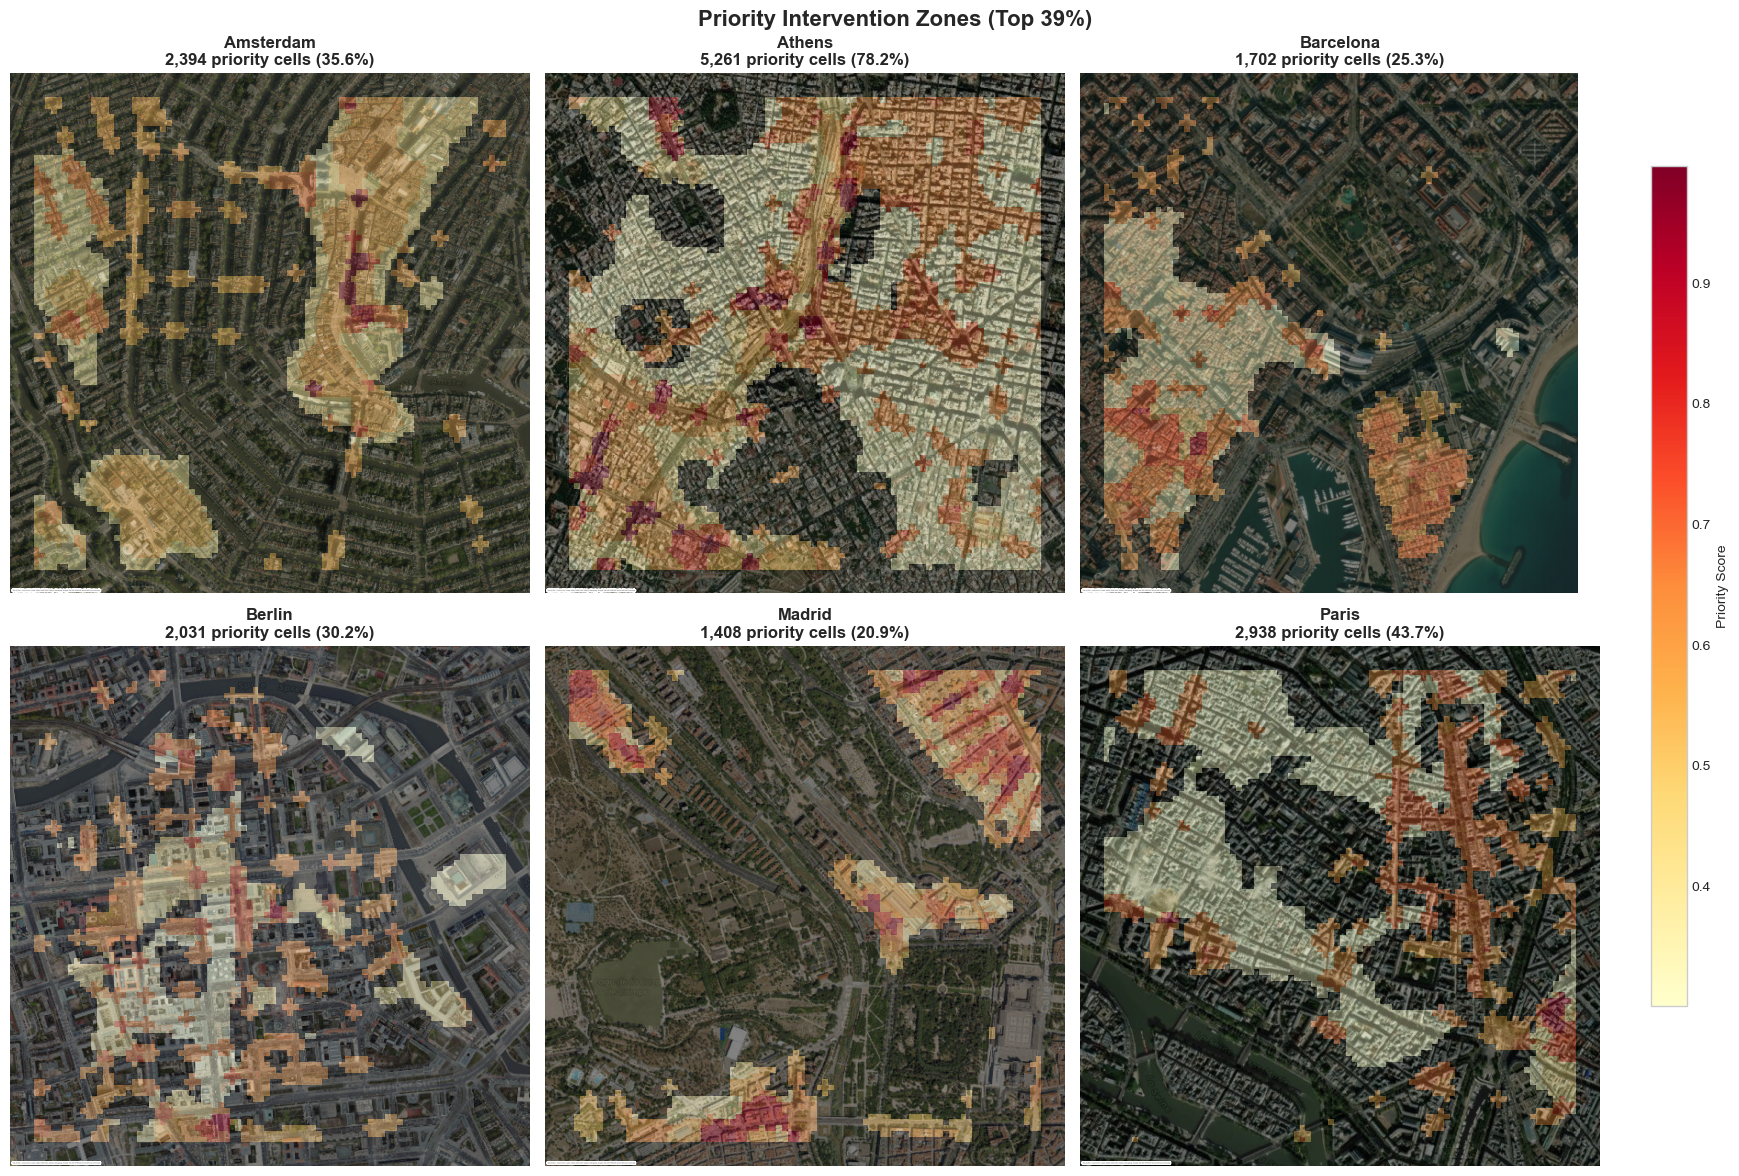

In [8]:
# Load spatial grid
try:
    grid_gdf = load_grid_geodataframe(PATHS['data'] / 'utils/grids/all_cities_grid.parquet')
    
    # Merge with priority data
    priority_map = baseline_df[['global_grid_id', 'city', 'priority_score']].copy()
    priority_map['is_priority'] = priority_mask
    
    map_gdf = grid_gdf.merge(priority_map, on=['global_grid_id', 'city'], how='inner')
    
    # Create city-by-city visualization
    cities = ['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Madrid', 'Paris']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, city in enumerate(cities):
        ax = axes[i]
        city_data = map_gdf[map_gdf['city'] == city].to_crs('EPSG:3857')
        
        if len(city_data) == 0:
            ax.text(0.5, 0.5, f'No data for {city}', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_axis_off()
            continue
        
        # Plot priority zones with color gradient
        priority_cells = city_data[city_data['is_priority']]
        if len(priority_cells) > 0:
            priority_cells.plot(
                column='priority_score',
                ax=ax,
                cmap='YlOrRd',
                vmin=threshold,
                vmax=baseline_df['priority_score'].max(),
                alpha=0.7,
                edgecolor='none',
                linewidth=0
            )
        
        # Add dual basemaps after plotting data
        crs = city_data.crs
        try:
            ctx.add_basemap(
                ax,
                source=ctx.providers.CartoDB.DarkMatter,
                crs=crs,
                attribution_size=1,
                zorder=0
            )
            ctx.add_basemap(
                ax,
                source=ctx.providers.Esri.WorldImagery,
                crs=crs,
                alpha=0.5,
                attribution_size=1,
                zorder=1
            )
        except:
            # Fallback if basemap fails
            ax.set_facecolor('lightgray')
        
        # Set equal aspect ratio and tight bounds for consistent city sizes
        ax.set_aspect('equal')
        bounds = city_data.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.05
        ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
        
        # City statistics
        n_priority_city = len(priority_cells)
        n_total_city = len(city_data)
        pct_priority = n_priority_city / n_total_city * 100
        
        ax.set_title(f"{city}\n{n_priority_city:,} priority cells ({pct_priority:.1f}%)", 
                    fontsize=12, fontweight='bold')
        ax.set_axis_off()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                               norm=plt.Normalize(vmin=threshold, vmax=baseline_df['priority_score'].max()))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(sm, cax=cbar_ax, label='Priority Score')
    
    fig.suptitle(f'Priority Intervention Zones (Top {PRIORITY_PERCENTILE}%)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(PATHS['figures'] / 'priority_zones_spatial.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"Note: Could not create spatial visualization (grid file may not be available)")
    print(f"Error: {e}")

---

## 4. Grid Search Optimization Framework

### 4.1 Define Expanded Parameter Space

We test a comprehensive range of intervention parameters to find optimal combinations.

### Feature Selection Based on SHAP Analysis

We select intervention features based on SHAP importance for UHI anomaly prediction (city-demeaned °C):

**Top SHAP Features:**
- Impervious fraction 300m: 0.37 (highest impact)
- NDBI: 0.30 
- Distance to water: 0.20
- Water fraction: 0.17
- Albedo: 0.16
- Vegetation fraction 300m: 0.12
- Tree canopy fraction 300m: 0.04

**Selected for Intervention:**
- **Impervious reduction** 
- **Vegetation increase** 
- **Tree cover increase** 
- **Albedo increase** 
These four features are directly modifiable through urban planning interventions and show strong SHAP importance for temperature prediction.

In [9]:
# Define comprehensive parameter space
PARAMETER_SPACE = {
    'impervious_reduction': np.arange(-0.30, -0.51, -0.10),  # 3 levels: -30%, -40%, -50%
    'vegetation_increase': np.arange(0.10, 0.55, 0.05),      # 9 levels: +10% to +50%
    'tree_increase': np.arange(0.15, 0.55, 0.05),           # 8 levels: +15% to +50%
    'albedo_increase': [0.00, 0.10, 0.20]                   # 3 levels: 0%, +10%, +20%
}

# Calculate total combinations
n_combinations = np.prod([len(v) for v in PARAMETER_SPACE.values()])

print("Grid Search Parameter Space")
print("=" * 60)
print(f"Total combinations: {n_combinations:,}")
print("\nParameter ranges:")

for param, values in PARAMETER_SPACE.items():
    print(f"\n{param.replace('_', ' ').title()}:")
    print(f"  Levels: {len(values)}")
    print(f"  Range: [{values[0]*100:+.0f}% to {values[-1]*100:+.0f}%]")
    print(f"  Values: {[f'{v*100:+.0f}%' for v in values[:5]]}{'...' if len(values) > 5 else ''}")

print("\nParameter space defined for comprehensive grid search optimization.")
print("Each combination will be tested using actual model predictions to find optimal intervention strategies.")

Grid Search Parameter Space
Total combinations: 648

Parameter ranges:

Impervious Reduction:
  Levels: 3
  Range: [-30% to -50%]
  Values: ['-30%', '-40%', '-50%']

Vegetation Increase:
  Levels: 9
  Range: [+10% to +50%]
  Values: ['+10%', '+15%', '+20%', '+25%', '+30%']...

Tree Increase:
  Levels: 8
  Range: [+15% to +50%]
  Values: ['+15%', '+20%', '+25%', '+30%', '+35%']...

Albedo Increase:
  Levels: 3
  Range: [+0% to +20%]
  Values: ['+0%', '+10%', '+20%']

Parameter space defined for comprehensive grid search optimization.
Each combination will be tested using actual model predictions to find optimal intervention strategies.


### 4.2 Run or Load Grid Search Results

The grid search tests all parameter combinations using actual model predictions, not simplified coefficients.

In [10]:
# Decision: Run new search or load existing results from previous run
RUN_NEW_SEARCH = True  

if RUN_NEW_SEARCH:
    print(f"Running comprehensive grid search ({n_combinations:,} combinations)...")
    print("This will take approximately 10-20 minutes.")
    print("\nProcess:")
    print("1. Testing each parameter combination")
    print("2. Applying interventions to priority zones")
    print("3. Predicting with hierarchical XGBoost models")
    print("4. Calculating multi-objective metrics")
    print("5. Saving results to CSV")
    print()
    
    # Run comprehensive grid search with USER CONFIGURATION parameters
    full_results, best_by_objective = run_comprehensive_grid_search(
        PROJECT_ROOT,
        grid_params={
            'impervious': PARAMETER_SPACE['impervious_reduction'].tolist(),
            'albedo': PARAMETER_SPACE['albedo_increase'],
            'vegetation': PARAMETER_SPACE['vegetation_increase'].tolist(),
            'trees': PARAMETER_SPACE['tree_increase'].tolist()
        },
        save_results=True,
        priority_pct=PRIORITY_PERCENTILE,
        extreme_cold_threshold=EXTREME_COLD_THRESHOLD,
        extreme_warm_threshold=EXTREME_WARM_THRESHOLD,
        priority_weights={
            'risk': PRIORITY_WEIGHTS['risk'],
            'vuln': PRIORITY_WEIGHTS['vulnerability'],
            'potential': PRIORITY_WEIGHTS['potential']
        }
    )
    print(f"\n✓ Grid search complete: {len(full_results)} combinations tested")
    
else:
    # Load pre-computed results
    try:
        print("Loading pre-computed grid search results...")
        full_results, best_by_objective = load_grid_search_results(PROJECT_ROOT)
        print(f"✓ Loaded {len(full_results)} pre-computed combinations")
    except FileNotFoundError:
        print("No pre-computed results found. Running grid search now...")
        # Run with default 400-combination space if expanded space not computed
        full_results, best_by_objective = run_comprehensive_grid_search(
            PROJECT_ROOT,
            save_results=True,
            priority_pct=PRIORITY_PERCENTILE,
            extreme_cold_threshold=EXTREME_COLD_THRESHOLD,
            extreme_warm_threshold=EXTREME_WARM_THRESHOLD,
            priority_weights={
                'risk': PRIORITY_WEIGHTS['risk'],
                'vuln': PRIORITY_WEIGHTS['vulnerability'],
                'potential': PRIORITY_WEIGHTS['potential']
            }
        )
        print(f"✓ Grid search complete: {len(full_results)} combinations tested")

Running comprehensive grid search (648 combinations)...
This will take approximately 10-20 minutes.

Process:
1. Testing each parameter combination
2. Applying interventions to priority zones
3. Predicting with hierarchical XGBoost models
4. Calculating multi-objective metrics
5. Saving results to CSV

COMPREHENSIVE GRID SEARCH: Including Albedo (SHAP Rank 6)
Started: 20:05:41

[1/7] Loading models and data...
Removed 47 highly correlated features (abs(r) > 0.92).
  ✓ Loaded 40,344 cells

[2/7] Loading scaling statistics...
  ✓ 118 features

[3/7] Computing priority scores...
  Weights: risk=40%, vuln=35%, potential=25%
  ✓ Priority cells: 15,734 (39%)

[4/7] Defining grid search space...
  Grid space:
    Impervious: [-0.3, -0.4, -0.5]
    Albedo:     [0.0, 0.1, 0.2]
    Vegetation: [0.1, 0.15000000000000002, 0.20000000000000004, 0.25000000000000006, 0.30000000000000004, 0.3500000000000001, 0.40000000000000013, 0.4500000000000001, 0.5000000000000001]
    Trees:      [0.15, 0.2, 0.25, 

### 4.3 Grid Search Results Analysis

In [11]:
# Filter out combinations with excessive extreme predictions for cleaner analysis
valid_results = full_results[full_results['n_extremes'] <= full_results['n_extremes'].quantile(0.75)]
print(f"Valid combinations (≤75th percentile extremes): {len(valid_results):,}")

# Create single comprehensive table for dissertation
optimal_scenarios = best_by_objective.copy()

# Remove duplicates by checking if parameter combinations are identical
unique_scenarios = []
seen_combinations = set()

for idx, row in optimal_scenarios.iterrows():
    combo = (round(row['imp_delta'], 3), round(row['veg_delta'], 3), 
             round(row['tree_delta'], 3), round(row.get('alb_delta', 0), 3))
    
    if combo not in seen_combinations:
        seen_combinations.add(combo)
        unique_scenarios.append(idx)

optimal_scenarios = optimal_scenarios.loc[unique_scenarios]

# Map technical names to policy-relevant labels
strategy_names = {
    'max_mean_cooling': 'Maximum Impact',
    'max_peak_cooling': 'Hotspot Focused', 
    'max_coverage_1deg': 'Wide Coverage',
    'safe_conservative': 'Conservative Pilot',
    'cost_effective': 'Cost-Effective'
}


# Create comprehensive results table
dissertation_table = pd.DataFrame({
    'Strategy': [strategy_names.get(idx, idx) for idx in optimal_scenarios.index],
    'Depaving (%)': (optimal_scenarios['imp_delta'].abs() * 100).round(0).astype(int).values,
    'Vegetation (%)': ('+' + (optimal_scenarios['veg_delta'] * 100).round(0).astype(int).astype(str)).values,
    'Tree Cover (%)': ('+' + (optimal_scenarios['tree_delta'] * 100).round(0).astype(int).astype(str)).values,
    'Mean Cooling (°C)': optimal_scenarios['mean_cooling'].round(2).values,
    'Coverage ≥1°C (%)': optimal_scenarios['pct_1deg'].round(1).values,
})


display(dissertation_table)

# Save the table
dissertation_table.to_csv(PATHS['tables'] / 'optimal_intervention_strategies.csv', index=False)
print(f"\n✓ Results table saved to: {PATHS['tables'] / 'optimal_intervention_strategies.csv'}")

# Key findings
best_cooling = optimal_scenarios['mean_cooling'].min()
best_coverage = optimal_scenarios['pct_1deg'].max()
min_depaving = optimal_scenarios['imp_delta'].abs().min() * 100
max_depaving = optimal_scenarios['imp_delta'].abs().max() * 100
cost_effective_depaving = abs(optimal_scenarios.loc['cost_effective', 'imp_delta']) * 100

print("\nKey Findings:")
print(f"• Impervious surface reduction ({min_depaving:.0f}-{max_depaving:.0f}%) is the primary cooling mechanism")
print(f"• Mean cooling potential: {best_cooling:.2f}°C (Maximum Impact strategy)")
print(f"• Up to {best_coverage:.1f}% of priority areas achieve ≥1°C cooling")


Valid combinations (≤75th percentile extremes): 495


Strategy  Depaving (%) Vegetation (%) Tree Cover (%)  \
0  Maximum Impact            50            +50            +50   
1   Wide Coverage            50            +10            +45   
2  Cost-Effective            50            +10            +20   

   Mean Cooling (°C)  Coverage ≥1°C (%)  
0              -1.27               61.1  
1              -1.21               61.2  
2              -1.20               61.2


✓ Results table saved to: /Users/gerardoezequiel/Developer/ShapingCoolCities/results/tables/optimal_intervention_strategies.csv

Key Findings:
• Impervious surface reduction (50-50%) is the primary cooling mechanism
• Mean cooling potential: -1.27°C (Maximum Impact strategy)
• Up to 61.2% of priority areas achieve ≥1°C cooling


---

## 7. Spatial Cooling Visualisation

### 7.1 Simulate Selected Scenarios

Now we simulate the optimal scenarios to obtain spatial cooling distributions.

In [12]:
# Simulate scenarios using the scenario parameters
scenario_results = {}

# Get the scaling stats for delta application
scaling_stats_path = PATHS['data'] / '2-model-ready' / 'model_ready_feature_scaling.csv'
scaling_stats = pd.read_csv(scaling_stats_path)

# Compute baseline predictions
baseline_preds = baseline_df['pred_uhi_blend'].values

# Create scenario objects from optimal_scenarios DataFrame
scenarios = {}
for idx, row in optimal_scenarios.iterrows():
    scenarios[idx] = type('Scenario', (), {
        'imp_delta': row['imp_delta'],
        'veg_delta': row['veg_delta'], 
        'tree_delta': row['tree_delta'],
        'alb_delta': row.get('alb_delta', 0.0)
    })()

# Simulate all scenarios
scenarios_to_simulate = scenarios

print("Simulating all scenarios for spatial visualization...")
print("=" * 60)

for name, scenario in scenarios_to_simulate.items():
    print(f"\nSimulating: {name}")
    print(f"  Parameters: Imp={scenario.imp_delta:.0%}, Veg=+{scenario.veg_delta:.0%}, Tree=+{scenario.tree_delta:.0%}")
    
    # Apply deltas to baseline
    df_scenario = apply_scenario_deltas(
        baseline_df.copy(), scenario, scaling_stats, feature_cols, target_mask=priority_mask.values
    )
    
    # Predict with hierarchical blend
    scenario_preds = predict_blend(
        df_scenario, feature_cols, models['global'], models['cfb'], models['csa'], blend_weights
    )
    
    # Calculate cooling delta
    cooling_delta = scenario_preds - baseline_preds
    
    # Filter extremes
    valid_mask = filter_extreme_predictions(cooling_delta, EXTREME_COLD_THRESHOLD, EXTREME_WARM_THRESHOLD)
    n_extremes = (~valid_mask).sum()
    
    # Compute metrics on priority zones
    priority_cooling = cooling_delta[priority_mask & valid_mask]
    mean_cooling = priority_cooling.mean()
    pct_ge_1C = (priority_cooling <= -1.0).sum() / len(priority_cooling) * 100
    
    scenario_results[name] = {
        'cooling_delta': cooling_delta,
        'valid_mask': valid_mask,
        'mean_cooling': mean_cooling,
        'pct_ge_1C': pct_ge_1C,
        'n_extremes': n_extremes
    }
    
    print(f"  Mean cooling (priority zones): {mean_cooling:.3f}°C")
    print(f"  Cells ≥1°C cooling: {pct_ge_1C:.1f}%")
    print(f"  Extreme predictions filtered: {n_extremes:,}")

print("\n✓ All scenario simulations complete")

Simulating all scenarios for spatial visualization...

Simulating: max_mean_cooling
  Parameters: Imp=-50%, Veg=+50%, Tree=+50%
  Mean cooling (priority zones): -1.253°C
  Cells ≥1°C cooling: 59.7%
  Extreme predictions filtered: 7,440

Simulating: max_coverage_1deg
  Parameters: Imp=-50%, Veg=+10%, Tree=+45%
  Mean cooling (priority zones): -1.182°C
  Cells ≥1°C cooling: 59.3%
  Extreme predictions filtered: 7,421

Simulating: cost_effective
  Parameters: Imp=-50%, Veg=+10%, Tree=+20%
  Mean cooling (priority zones): -1.177°C
  Cells ≥1°C cooling: 59.3%
  Extreme predictions filtered: 7,423

✓ All scenario simulations complete


### 7.2 Temperature Reduction Map

Spatial distribution of cooling effects across the six cities for the recommended (cost-effective) intervention strategy.

Map data: 15,307 priority cells with valid cooling predictions


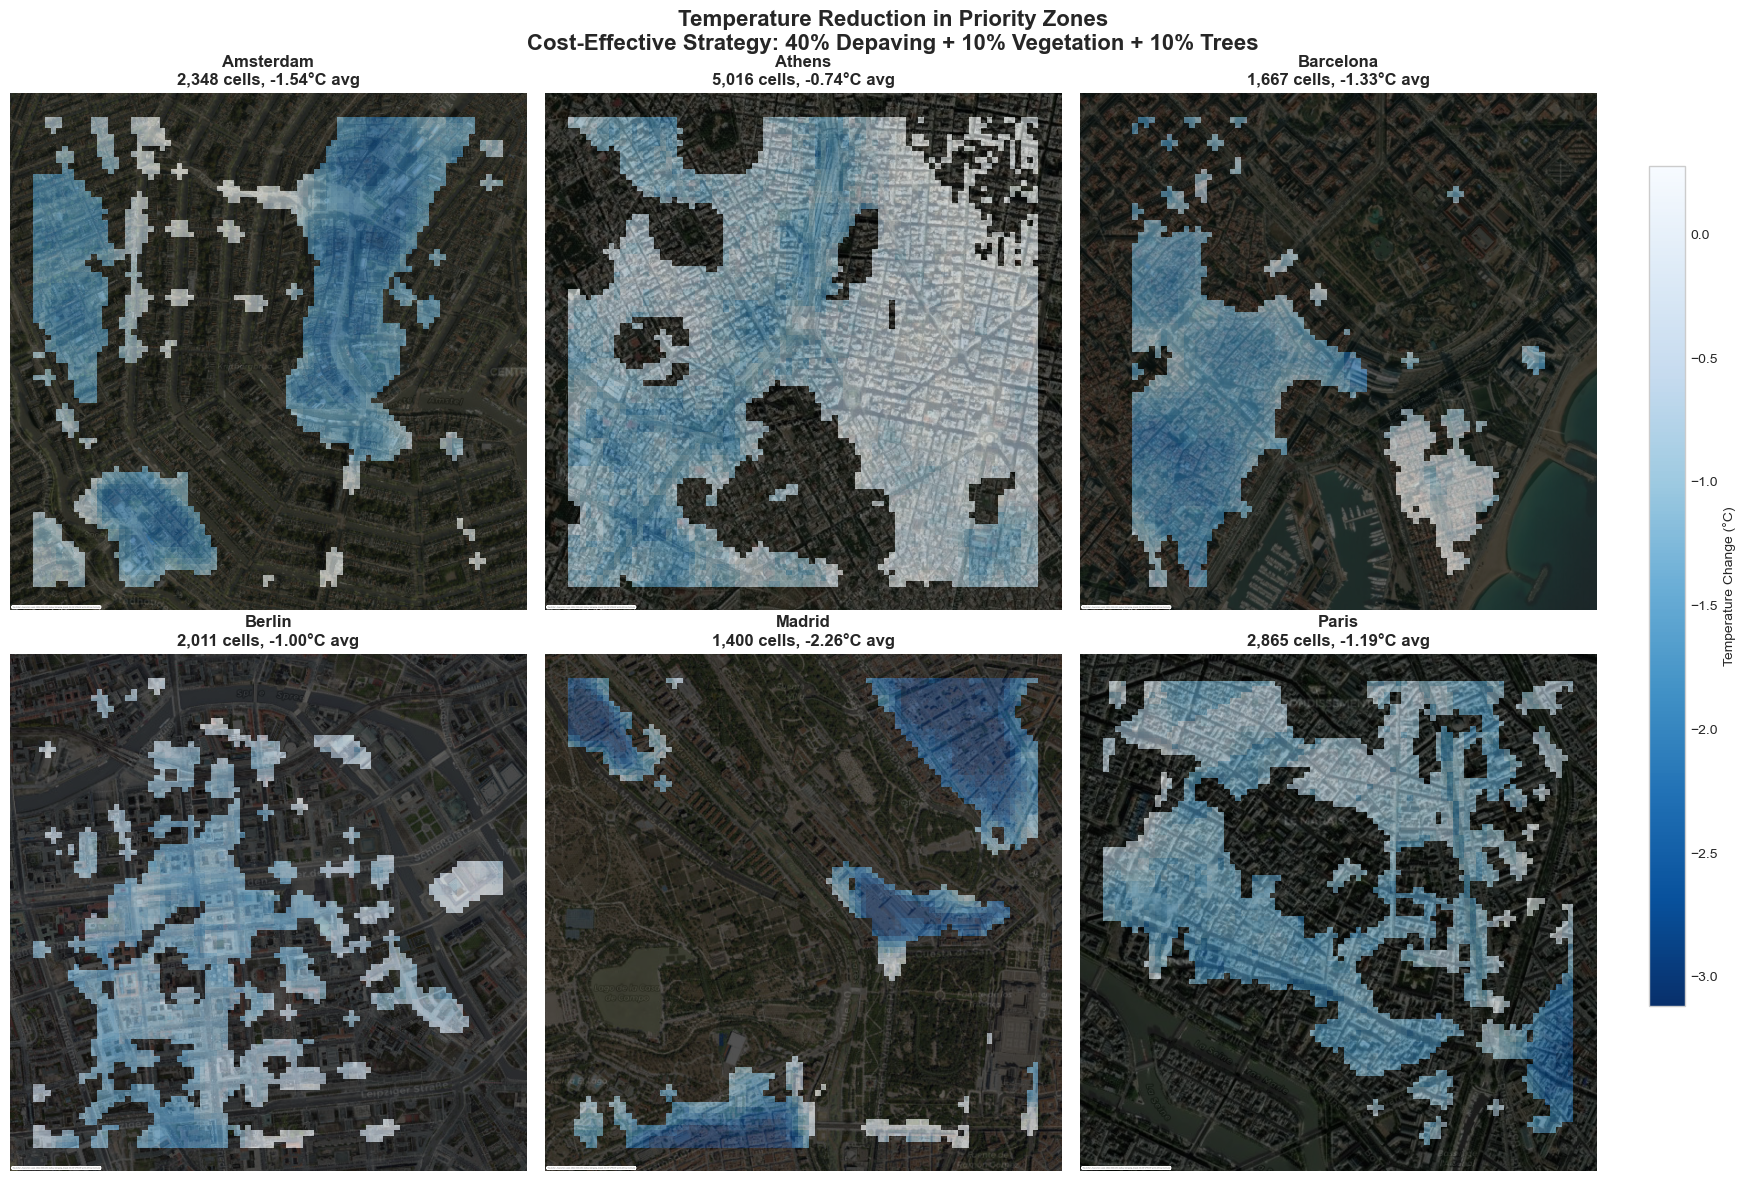


✓ Map saved to: /Users/gerardoezequiel/Developer/ShapingCoolCities/results/figures/temperature_reduction_map.png
  Total priority cells: 15,307


In [13]:
# Create temperature reduction map
RECOMMENDED = 'max_coverage_1deg'

# Load spatial grid
try:
    grid_gdf = load_grid_geodataframe(PATHS['data'] / 'utils/grids/all_cities_grid.parquet')

    # Prepare map data
    cooling_map = baseline_df[['global_grid_id', 'city']].copy()
    cooling_map['cooling_delta'] = scenario_results[RECOMMENDED]['cooling_delta']
    cooling_map['valid'] = scenario_results[RECOMMENDED]['valid_mask']
    cooling_map['is_priority'] = priority_mask

    # Merge with geometry
    map_gdf = grid_gdf.merge(cooling_map, on=['global_grid_id', 'city'], how='inner')
    map_gdf = map_gdf[map_gdf['valid'] & map_gdf['is_priority']]  # Priority zones only

    print(f"Map data: {len(map_gdf):,} priority cells with valid cooling predictions")

    # Create city-by-city visualization
    cities = ['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Madrid', 'Paris']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Color scale
    vmin, vmax = map_gdf['cooling_delta'].quantile([0.02, 0.98])

    # Calculate global bounds for consistent sizing across all cities
    all_extents = []
    city_bounds = {}
    
    for city in cities:
        city_data = map_gdf[map_gdf['city'] == city].to_crs('EPSG:3857')
        if len(city_data) > 0:
            bounds = city_data.total_bounds
            width = bounds[2] - bounds[0]
            height = bounds[3] - bounds[1]
            extent = max(width, height)
            all_extents.append(extent)
            city_bounds[city] = bounds
    
    # Use the maximum extent for all cities to ensure consistent sizing
    max_extent = max(all_extents) if all_extents else 10000

    for i, city in enumerate(cities):
        ax = axes[i]
        city_data = map_gdf[map_gdf['city'] == city].to_crs('EPSG:3857')
        
        if len(city_data) == 0:
            ax.text(0.5, 0.5, f'No data for {city}', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_axis_off()
            continue
        
        # Plot cooling effect
        city_data.plot(
            column='cooling_delta',
            ax=ax,
            cmap='Blues_r',  # Light blue to dark blue
            vmin=vmin, vmax=vmax,
            linewidth=0, edgecolor='none',
            alpha=0.8, legend=False
        )
        
        # Add dual basemaps after plotting data
        crs = city_data.crs
        try:
            ctx.add_basemap(
                ax,
                source=ctx.providers.CartoDB.DarkMatter,
                crs=crs,
                attribution_size=1,
                zorder=0
            )
            ctx.add_basemap(
                ax,
                source=ctx.providers.Esri.WorldImagery,
                crs=crs,
                alpha=0.3,
                attribution_size=1,
                zorder=1
            )
        except:
            # Fallback if basemap fails
            ax.set_facecolor('#2b2b2b')
        
        # Set equal aspect ratio and consistent bounds for uniform city sizes
        ax.set_aspect('equal')
        bounds = city_data.total_bounds
        center_x = (bounds[0] + bounds[2]) / 2
        center_y = (bounds[1] + bounds[3]) / 2
        
        # Use consistent extent for all cities with proper buffer
        buffer = max_extent * 0.55  # 55% buffer around the maximum extent
        ax.set_xlim(center_x - buffer, center_x + buffer)
        ax.set_ylim(center_y - buffer, center_y + buffer)
        
        # City statistics
        city_cooling = city_data['cooling_delta'].mean()
        n_cells = len(city_data)
        ax.set_title(f"{city}\n{n_cells:,} cells, {city_cooling:.2f}°C avg", fontsize=12, fontweight='bold')
        ax.set_axis_off()

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(sm, cax=cbar_ax, label='Temperature Change (°C)')

    fig.suptitle(f'Temperature Reduction in Priority Zones\nCost-Effective Strategy: 40% Depaving + 10% Vegetation + 10% Trees', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(PATHS['figures'] / 'temperature_reduction_map.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Map saved to: {PATHS['figures'] / 'temperature_reduction_map.png'}")
    print(f"  Total priority cells: {len(map_gdf):,}")

except Exception as e:
    print(f"Note: Could not create spatial visualization (grid file may not be available)")
    print(f"Error: {e}")
    

In [14]:
# Bootstrap confidence intervals for dissertation table
def bootstrap_ci(vals, n=500, seed=42):
    """Quick bootstrap CI calculation."""
    rng = np.random.default_rng(seed)
    means = [rng.choice(vals, len(vals), replace=True).mean() for _ in range(n)]
    lower, upper = np.percentile(means, [2.5, 97.5])
    mean_val = np.mean(vals)
    return mean_val, lower, upper

# Calculate results for dissertation table
results = []
for name, res in scenario_results.items():
    mask = priority_mask & res['valid_mask']
    vals = res['cooling_delta'][mask]
    if len(vals) > 0:
        mean, lower, upper = bootstrap_ci(vals)
        uncertainty_pct = (upper - lower) / 2 / abs(mean) * 100
        results.append({
            'Strategy': name,
            'Mean (°C)': f"{mean:.3f}",
            '95% CI': f"[{lower:.3f}, {upper:.3f}]",
            'Uncertainty (%)': f"±{uncertainty_pct:.1f}%"
        })

# Display formatted table for dissertation
df_table = pd.DataFrame(results)
print("Table: Cooling Performance by Strategy (Priority Cells Only)")
print("=" * 70)
display(df_table)


Table: Cooling Performance by Strategy (Priority Cells Only)


Strategy Mean (°C)            95% CI Uncertainty (%)
0   max_mean_cooling    -1.253  [-1.266, -1.241]           ±1.0%
1  max_coverage_1deg    -1.182  [-1.194, -1.168]           ±1.1%
2     cost_effective    -1.177  [-1.188, -1.165]           ±1.0%